# Planar element response

Original code see:
[Solid-fluid fully coupled (u-p) plane-strain 9-4 noded element: saturated soil element with pressure dependent material, subjected to 1D sinusoidal base shaking](https://opensees.berkeley.edu/wiki/index.php?title=PressureDependMultiYield02-Example_1)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops

import opstool as opst


## Model

In [2]:
ops.wipe()
ops.model("basic", "-ndm", 2, "-ndf", 3)
ops.node(1, 0, 0)
ops.node(2, 2.5, 0)
ops.node(3, 2.5, 2)
ops.node(4, 0, 2)
ops.fix(1, 1, 1, 0)
ops.fix(2, 1, 1, 0)
ops.fix(3, 0, 0, 1)
ops.fix(4, 0, 0, 1)
ops.equalDOF(3, 4, 1, 2)
ops.model("basic", "-ndm", 2, "-ndf", 2)
ops.node(5, 1.25, 0.0)
ops.node(6, 2.5, 1)
ops.node(7, 1.25, 2)
ops.node(8, 0, 1)
ops.node(9, 1.25, 1)
ops.fix(5, 1, 1)
ops.equalDOF(3, 7, 1, 2)
ops.equalDOF(6, 8, 1, 2)
ops.equalDOF(6, 9, 1, 2)
ops.nDMaterial(
    "PressureDependMultiYield02", 1, 2, 1.8, 90000.0, 220000.0, 32, 0.1, 80, 0.5, 26.0, 0.067, 0.23, 0.06, 0.27
)
ops.element("9_4_QuadUP", 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1.0, 1, 2200000.0, 1, 5.1e-07, 5.1e-07, 0.0, -9.81)

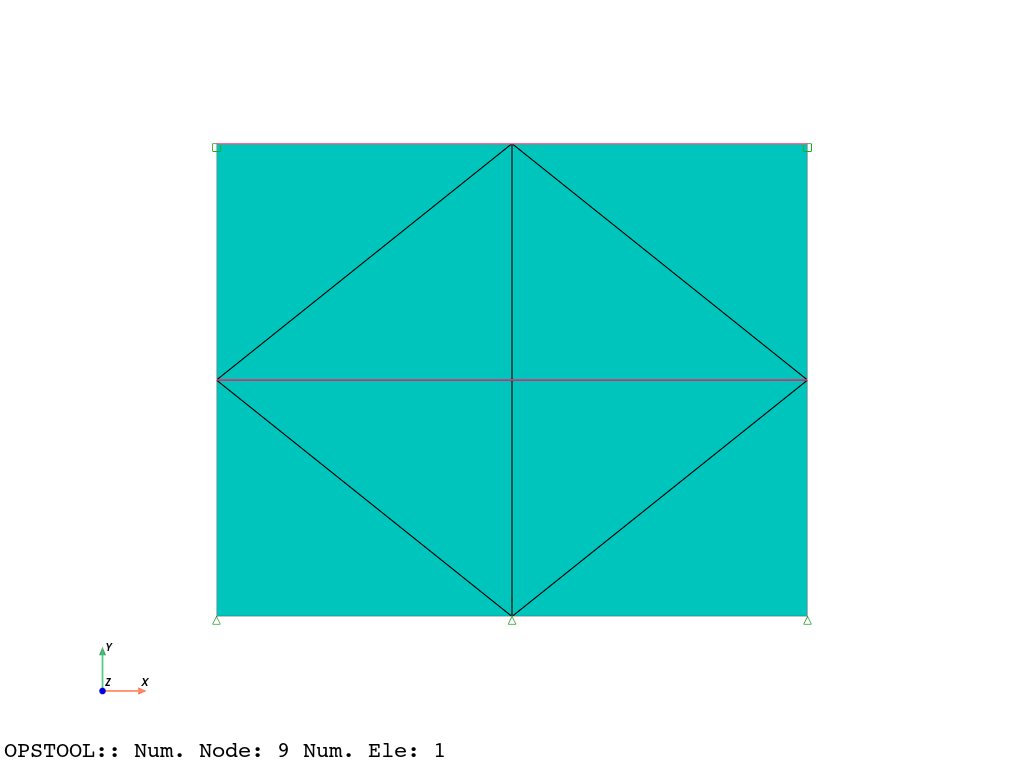

In [3]:
opsvis = opst.vis.pyvista

opsvis.set_plot_props(notebook=True)
fig = opsvis.plot_model()
fig.show(jupyter_backend="jupyterlab")

## GRAVITY APPLICATION (elastic behavior)

In [4]:
# create the SOE, ConstraintHandler, Integrator, Algorithm and Numberer
ops.updateMaterialStage("-material", 1, "-stage", 0)
ops.numberer("RCM")
ops.system("ProfileSPD")
ops.test("NormDispIncr", 1e-08, 30, 0)
ops.algorithm("KrylovNewton")
ops.constraints("Penalty", 1e18, 1e18)
ops.integrator("Newmark", 1.5, 1.0)
ops.analysis("Transient")
ops.analyze(10, 5000.0)
ops.updateMaterialStage("-material", 1, "-stage", 1)
ops.analyze(100, 1.0)

0

## APPLY LOADING SEQUENCE AND ANALYZE (plastic)

In [5]:
ops.wipeAnalysis()
ops.setTime(0.0)
ops.timeSeries("Trig", 1, 0.0, 10.0, 1.0, "-factor", 2)
ops.pattern("UniformExcitation", 1, 1, "-accel", 1)

In [6]:
ops.constraints("Penalty", 1e18, 1e18)
ops.test("NormDispIncr", 0.0001, 25, 0)
ops.numberer("RCM")
ops.algorithm("KrylovNewton")
ops.system("ProfileSPD")
ops.integrator("Newmark", 0.6, 0.30250000000000005)
ops.rayleigh(0.0, 0.0, 0.002, 0.0)
ops.analysis("Transient")

### Save the results

``compute_mechanical_measures`` is used to compute the mechanical measures, including various stress and strain measures.

``project_gauss_to_nodes`` is used to project the Gauss point results to the nodes.

* "copy": The response of each node is copied from the Gaussian point closest to it.
* "average": The response of each node is equal to the weighted average of the responses of all Gaussian points of the element, with the weight being the integration point weight.
* "extrapolate": The nodal responses are obtained by extrapolating the element shape functions.

In [7]:
ODB = opst.post.CreateODB(
    odb_tag=1,
    compute_mechanical_measures=True,
    project_gauss_to_nodes="copy",  # "extrapolate", "copy", "average"
)
for _ in range(2500):
    ops.analyze(1, 0.01)
    ODB.fetch_response_step()
ODB.save_response(zlib=True)

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

## Post-processing

### Nodal responses

In [8]:
node_resp = opst.post.get_nodal_responses(odb_tag=1)
print(node_resp)

OPSTOOL ::  Loading all response data from .opstool.output/RespStepData-1.nc ...

<xarray.Dataset> Size: 3MB
Dimensions:             (time: 2501, nodeTags: 9, DOFs: 6)
Coordinates:
  * time                (time) float64 20kB 0.0 0.01 0.02 ... 24.98 24.99 25.0
  * nodeTags            (nodeTags) int32 36B 1 2 3 4 5 6 7 8 9
  * DOFs                (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
Data variables:
    disp                (time, nodeTags, DOFs) float32 540kB -9.002e-18 ... 0.0
    vel                 (time, nodeTags, DOFs) float32 540kB -2.544e-29 ... 0.0
    accel               (time, nodeTags, DOFs) float32 540kB 9.869e-31 ... 0.0
    reaction            (time, nodeTags, DOFs) float32 540kB 2.462 7.903 ... 0.0
    reactionIncInertia  (time, nodeTags, DOFs) float32 540kB 9.002 14.72 ... 0.0
    rayleighForces      (time, nodeTags, DOFs) float32 540kB -4.705e-14 ... 0.0
    pressure            (time, nodeTags) float32 90kB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    UX:       Displacement in X direction
    UY:       Displacement in Y direction
    UZ:       Displ

#### node 3 displacement relative to node 1

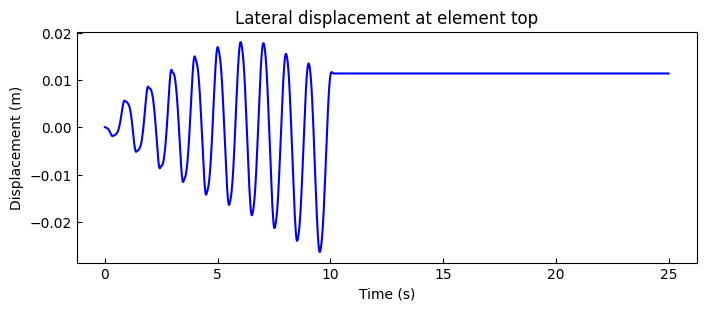

In [9]:
disp1 = node_resp["disp"].sel(nodeTags=1, DOFs="UX")
disp3 = node_resp["disp"].sel(nodeTags=3, DOFs="UX")
times = node_resp["time"].data

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, disp3 - disp1, "b")
ax.set_title("Lateral displacement at element top")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Displacement (m)")
plt.show()

#### node 3 acceleration

In [10]:
from scipy.interpolate import interp1d


t = np.linspace(0, 20 * np.pi, int(20 * np.pi / (np.pi / 50)) + 1)
s = 2 * np.sin(t)
s = np.concatenate((s, np.zeros(3000)))
x_original = np.linspace(0, 40, len(s))
interp_func = interp1d(x_original, s, kind="linear", fill_value="extrapolate")
s1 = interp_func(times)

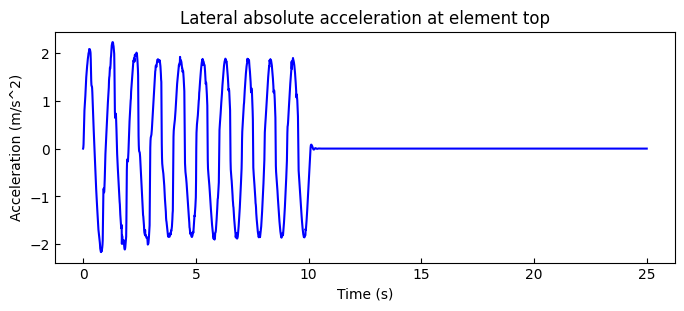

In [11]:
acc3 = node_resp["accel"].sel(nodeTags=3, DOFs="UX")
times = node_resp["time"].data

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, s1 + acc3, "b")
ax.set_title("Lateral absolute acceleration at element top")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Acceleration (m/s^2)")
plt.show()

#### Pore pressure at base

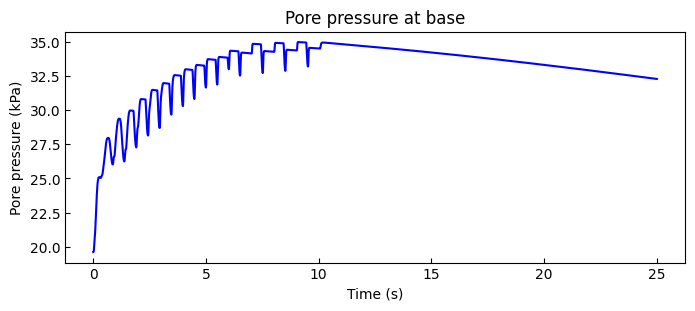

In [12]:
p1 = node_resp["vel"].sel(nodeTags=1, DOFs="RZ")

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(times, p1, "b")
ax.set_title("Pore pressure at base")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pore pressure (kPa)")
plt.show()

### Elemental response

In [13]:
ele_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Plane")

OPSTOOL ::  Loading Plane response data from .opstool.output/RespStepData-1.nc ...

In [14]:
print("Data Variables in Element Responses:", ele_resp.data_vars)

Data Variables in Element Responses: Data variables:
    Stresses               (time, eleTags, GaussPoints, stressDOFs) float32 450kB ...
    Strains                (time, eleTags, GaussPoints, strainDOFs) float32 270kB ...
    StressesAtNodes        (time, nodeTags, stressDOFs) float32 450kB -6.554 ...
    StrainsAtNodes         (time, nodeTags, strainDOFs) float32 270kB 1.229e-...
    StressAtNodesErr       (time, nodeTags, stressDOFs) float32 450kB 0.0 ......
    StrainsAtNodesErr      (time, nodeTags, strainDOFs) float32 270kB 0.0 ......
    stressMeasures         (time, eleTags, GaussPoints, measures) float32 360kB ...
    strainMeasures         (time, eleTags, GaussPoints, measures) float32 360kB ...
    StressMeasuresAtNodes  (time, nodeTags, measures) float32 360kB -6.554 .....
    StrainMeasuresAtNodes  (time, nodeTags, measures) float32 360kB 0.0 ... 0...


#### Gauss point responses

Extract the stresses of element 1

In [15]:
sigma11 = ele_resp["Stresses"].sel(stressDOFs="sigma11", eleTags=1)
sigma22 = ele_resp["Stresses"].sel(stressDOFs="sigma22", eleTags=1)
sigma33 = ele_resp["Stresses"].sel(stressDOFs="sigma33", eleTags=1)
sigma12 = ele_resp["Stresses"].sel(stressDOFs="sigma12", eleTags=1)
eta_r = ele_resp["Stresses"].sel(stressDOFs="eta_r", eleTags=1)

Calculate confinement p and deviatoric stress q

In [16]:
po = (sigma11 + sigma22 + sigma33) / 3.0
qo = (sigma11 - sigma22) ** 2 + (sigma22 - sigma33) ** 2 + (sigma33 - sigma11) ** 2 + 6 * (sigma12**2)
qo = np.sign(sigma12) * 1 / 3 * np.sqrt(qo)
print(qo)

<xarray.DataArray 'Stresses' (time: 2501, GaussPoints: 9)> Size: 90kB
array([[-3.4757295 ,  3.4757295 , -0.44147557, ..., -0.44147557,
         1.9586024 ,  1.9586024 ],
       [-3.4746075 , -3.4746075 , -0.44140658, ..., -0.44140658,
        -1.9582562 , -1.9582562 ],
       [-3.4695098 , -3.4695098 , -0.44015568, ..., -0.44015568,
        -1.9558567 , -1.9558567 ],
       ...,
       [-0.50430477, -0.50430477, -0.07051354, ..., -0.07051354,
         0.2709114 ,  0.2709114 ],
       [-0.504708  , -0.504708  , -0.0705704 , ..., -0.0705704 ,
         0.27112103,  0.27112103],
       [-0.50511146, -0.50511146, -0.07062731, ..., -0.07062731,
         0.2713308 ,  0.2713308 ]], dtype=float32)
Coordinates:
  * time         (time) float32 10kB 0.0 0.01 0.02 0.03 ... 24.98 24.99 25.0
    eleTags      int32 4B 1
  * GaussPoints  (GaussPoints) int32 36B 1 2 3 4 5 6 7 8 9
    stressDOFs   <U7 28B 'sigma12'


Extract the strains of element 1

In [17]:
eps11 = ele_resp["Strains"].sel(strainDOFs="eps11", eleTags=1)
eps22 = ele_resp["Strains"].sel(strainDOFs="eps22", eleTags=1)
eps12 = ele_resp["Strains"].sel(strainDOFs="eps12", eleTags=1)

#### integration point 1 p-q

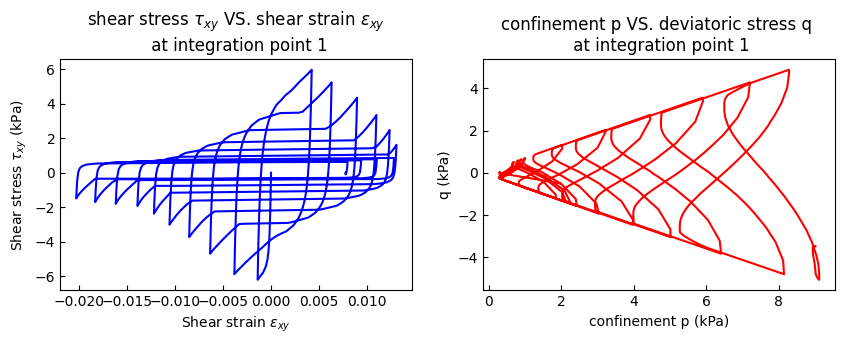

In [18]:
eps12_ele1_1 = eps12.sel(GaussPoints=1)
sigma12_ele1_1 = sigma12.sel(GaussPoints=1)
po_ele1_1 = po.sel(GaussPoints=1)
qo_ele1_1 = qo.sel(GaussPoints=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(eps12_ele1_1, sigma12_ele1_1, "b")
axs[0].set_title("shear stress $\\tau_{xy}$ VS. shear strain $\\epsilon_{xy}$ \n at integration point 1")
axs[0].set_xlabel(r"Shear strain $\epsilon_{xy}$")
axs[0].set_ylabel(r"Shear stress $\tau_{xy}$ (kPa)")
axs[1].plot(-po_ele1_1, qo_ele1_1, "r")
axs[1].set_title("confinement p VS. deviatoric stress q \n at integration point 1")
axs[1].set_xlabel("confinement p (kPa)")
axs[1].set_ylabel("q (kPa)")
plt.show()

#### integration point 5 p-q

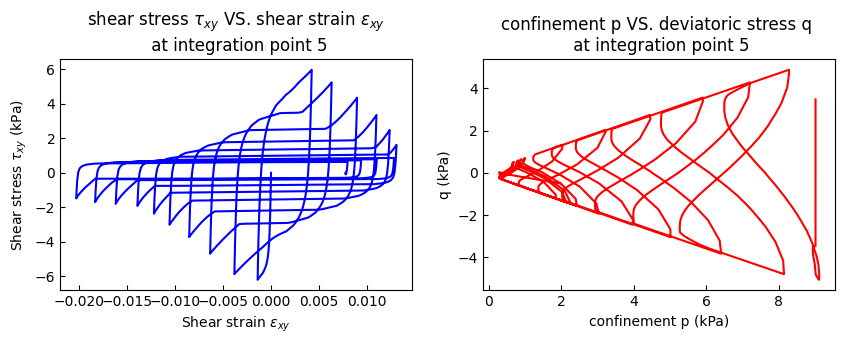

In [19]:
eps12_ele1_5 = eps12.sel(GaussPoints=5)
sigma12_ele1_5 = sigma12.sel(GaussPoints=5)
po_ele1_5 = po.sel(GaussPoints=5)
qo_ele1_5 = qo.sel(GaussPoints=5)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(eps12_ele1_5, sigma12_ele1_5, "b")
axs[0].set_title("shear stress $\\tau_{xy}$ VS. shear strain $\\epsilon_{xy}$ \n at integration point 5")
axs[0].set_xlabel(r"Shear strain $\epsilon_{xy}$")
axs[0].set_ylabel(r"Shear stress $\tau_{xy}$ (kPa)")
axs[1].plot(-po_ele1_5, qo_ele1_5, "r")
axs[1].set_title("confinement p VS. deviatoric stress q \n at integration point 5")
axs[1].set_xlabel("confinement p (kPa)")
axs[1].set_ylabel("q (kPa)")
plt.show()

#### integration point 9 p-q

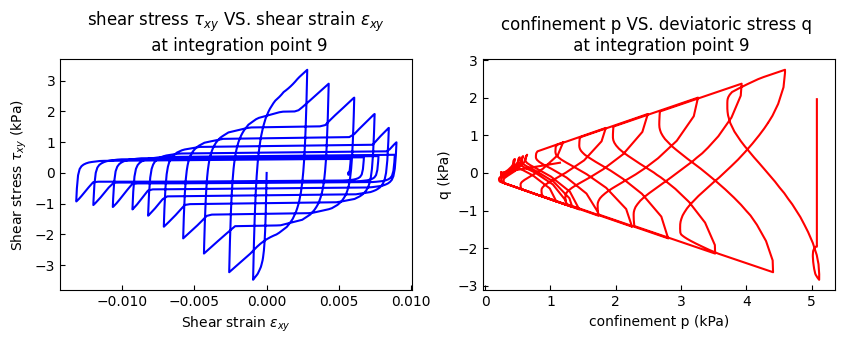

In [20]:
eps12_ele1_9 = eps12.sel(GaussPoints=9)
sigma12_ele1_9 = sigma12.sel(GaussPoints=9)
po_ele1_9 = po.sel(GaussPoints=9)
qo_ele1_9 = qo.sel(GaussPoints=9)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(eps12_ele1_9, sigma12_ele1_9, "b")
axs[0].set_title("shear stress $\\tau_{xy}$ VS. shear strain $\\epsilon_{xy}$ \n at integration point 9")
axs[0].set_xlabel(r"Shear strain $\epsilon_{xy}$")
axs[0].set_ylabel(r"Shear stress $\tau_{xy}$ (kPa)")
axs[1].plot(-po_ele1_9, qo_ele1_9, "r")
axs[1].set_title("confinement p VS. deviatoric stress q \n at integration point 9")
axs[1].set_xlabel("confinement p (kPa)")
axs[1].set_ylabel("q (kPa)")
plt.show()

#### Nodal Stresses

In [21]:
print("Dimensions:", ele_resp["StressesAtNodes"].dims)
print("Coords: ", ele_resp["StressesAtNodes"].coords)

Dimensions: ('time', 'nodeTags', 'stressDOFs')
Coords:  Coordinates:
  * time        (time) float32 10kB 0.0 0.01 0.02 0.03 ... 24.98 24.99 25.0
  * stressDOFs  (stressDOFs) <U7 140B 'sigma11' 'sigma22' ... 'sigma33' 'eta_r'
  * nodeTags    (nodeTags) int32 36B 1 2 3 4 5 6 7 8 9


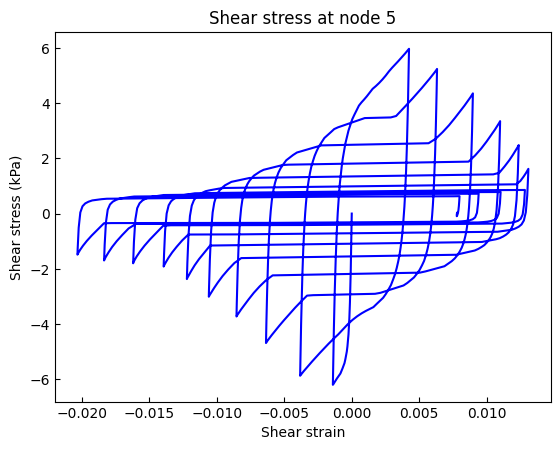

In [22]:
sxy5 = ele_resp["StressesAtNodes"].sel(stressDOFs="sigma12", nodeTags=5)
exy5 = ele_resp["StrainsAtNodes"].sel(strainDOFs="eps12", nodeTags=5)

plt.plot(exy5, sxy5, "b")
plt.title("Shear stress at node 5")
plt.xlabel("Shear strain")
plt.ylabel("Shear stress (kPa)")
plt.show()